In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
training_csv='./melanoma-image-data/train.csv'
test_csv='./melanoma-image-data/test.csv'
train_dataframe=pd.read_csv(training_csv)
test_dataframe=pd.read_csv(test_csv)
train_dataframe.head(7)

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0
5,ISIC_0074311,IP_2950485,female,40.0,lower extremity,unknown,benign,0
6,ISIC_0074542,IP_4698288,male,25.0,lower extremity,unknown,benign,0


In [3]:
train_dataframe['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

In [4]:
benign_data=train_dataframe[train_dataframe['target']==0]
maligant_data=train_dataframe[train_dataframe['target']==1]

benign_data=benign_data.reset_index()
maligant_data=maligant_data.reset_index()

print(benign_data.shape[0])
print(maligant_data.shape[0])

32542
584


In [5]:
#train_bening_data
train_benign_dir='./melanoma-image-data/train/train/benign/'
data_benign = []
labels_benign =[]


train_maligant_dir='./melanoma-image-data/train/train/malignant/'
data_maligant = []
labels_maligant =[]

for i in range(benign_data.shape[0]):
    data_benign.append(train_benign_dir+benign_data['image_name'].iloc[i]+'.jpg')
    labels_benign.append(benign_data['target'].iloc[i])
df_benign=pd.DataFrame(data_benign)
df_benign.columns=['images']
df_benign['target']=labels_benign


for i in range(maligant_data.shape[0]):
    data_maligant.append(train_maligant_dir+maligant_data['image_name'].iloc[i]+'.jpg')
    labels_maligant.append(maligant_data['target'].iloc[i])
df_maligant=pd.DataFrame(data_maligant)
df_maligant.columns=['images']
df_maligant['target']=labels_maligant

print(df_benign.shape)
print(df_maligant.shape)

df=pd.concat([df_benign,df_maligant])
df.shape

(32542, 2)
(584, 2)


(33126, 2)

In [6]:
test_dir='./melanoma-image-data/test/test/unkown/'
test_data = []
for i in range(test_dataframe.shape[0]):
    test_data.append(test_dir + test_dataframe['image_name'].iloc[i]+'.jpg')
df_test_kaggle=pd.DataFrame(test_data)
df_test_kaggle.columns=['images']
df_test_kaggle.shape
df_test_kaggle

,images
0,./melanoma-image-data/test/test/unkown/ISIC_00...
1,./melanoma-image-data/test/test/unkown/ISIC_00...
2,./melanoma-image-data/test/test/unkown/ISIC_00...
3,./melanoma-image-data/test/test/unkown/ISIC_00...
4,./melanoma-image-data/test/test/unkown/ISIC_00...
...,...
10977,./melanoma-image-data/test/test/unkown/ISIC_99...
10978,./melanoma-image-data/test/test/unkown/ISIC_99...
10979,./melanoma-image-data/test/test/unkown/ISIC_99...
10980,./melanoma-image-data/test/test/unkown/ISIC_99...


In [7]:
from sklearn.model_selection import train_test_split
x_train,x_val,y_train,y_val=train_test_split(df['images'],df['target'],test_size=0.2,random_state=42,stratify=df['target'])

train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
val_gen = pd.DataFrame({'image_dir': x_val, 'target': y_val})

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train_gen['image_dir'],train_gen['target'],test_size=0.1,random_state=42,stratify=train_gen['target'])

y_test_conf=y_test

train_gen = pd.DataFrame({'image_dir': x_train, 'target': y_train})
test_gen = pd.DataFrame({'image_dir': x_test, 'target': y_test})

In [9]:
from keras.layers import Input,Lambda,Dense,Flatten,Conv2D, MaxPooling2D, Dropout
from keras.applications.inception_resnet_v2 import InceptionResNetV2,preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob

from keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.metrics import AUC
from keras.activations import sigmoid
from keras.models import Model,load_model

from keras.optimizers import Adam
import tensorflow as tf


from tensorflow.python.keras import backend as K
from livelossplot import PlotLossesKeras


2023-03-20 01:01:45.174332: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-20 01:01:48.691087: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-20 01:01:48.691126: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-20 01:01:56.191233: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [10]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=45,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   zoom_range = 0.2,
                                   fill_mode ='nearest',
                                   horizontal_flip=True)
val_datagen=ImageDataGenerator(preprocessing_function =preprocess_input)
test_datagen =ImageDataGenerator(preprocessing_function =preprocess_input)


train_generator = train_datagen.flow_from_dataframe(
    train_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')

validation_generator = val_datagen.flow_from_dataframe(
    val_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw')




Found 23850 validated image filenames.
Found 6626 validated image filenames.


In [11]:

base_model= InceptionResNetV2(weights='imagenet',input_shape=(224,224,3),include_top=False)

for layer in base_model.layers:
    layer.trainable = False
    
layer_top=Flatten()(base_model.output)
layer_top=layers.Dense(1, activation = 'sigmoid')(layer_top)

model =Model(inputs=base_model.input,outputs=layer_top)
#model.summary()

2023-03-20 01:02:08.928540: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-20 01:02:08.928626: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-20 01:02:08.928696: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (skin-cancer-v2): /proc/driver/nvidia/version does not exist
2023-03-20 01:02:08.936679: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
def calculate_alpha(beta = 0.999):
     bening_sample=[23430,420]
     effective_num=1-np.power(beta,bening_sample)
     weights=(1.0-beta)/np.array(effective_num)
     weights=weights/np.sum(weights)*2
     return weights

alpha=calculate_alpha()
print(alpha[0])
print(alpha[1])

0.5108978868851661
1.4891021131148336


In [14]:
opt = Adam(lr=0.0001)
auc = tf.keras.metrics.AUC()

model.compile(loss=tf.keras.losses.BinaryFocalCrossentropy(
    alpha=alpha[0],
    gamma=1),
    optimizer = opt,
    metrics =[auc])

/opt/conda/lib/python3.7/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [17]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='InceptionResNetV2_focalloss_AUC_model1.h5',
                     monitor='auc',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'auc', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=128,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=32,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
128/128 [==============================] - 1550s 12s/step - loss: 0.0926 - auc: 0.5119 - val_loss: 0.0628 - val_auc: 0.6342
Epoch 2/30
128/128 [==============================] - 1377s 11s/step - loss: 0.0524 - auc: 0.6541 - val_loss: 0.0578 - val_auc: 0.7230
Epoch 3/30
128/128 [==============================] - 1333s 10s/step - loss: 0.0610 - auc: 0.6906 - val_loss: 0.0508 - val_auc: 0.7088
Epoch 4/30
128/128 [==============================] - 1164s 9s/step - loss: 0.0541 - auc: 0.7150 - val_loss: 0.0538 - val_auc: 0.7193
Epoch 5/30
128/128 [==============================] - 1133s 9s/step - loss: 0.0617 - auc: 0.6845 - val_loss: 0.0806 - val_auc: 0.6671
Epoch 6/30
128/128 [==============================] - 1114s 9s/step - loss: 0.0530 - auc: 0.7640 - val_loss: 0.0513 - val_auc: 0.7272
Epoch 7/30
128/128 [==============================] - 1089s 9s/step - loss: 0.0588 - auc: 0.7069 - val_loss: 0.0604 - val_auc: 0.7082
Epoch 8/30
128/128 [==============================] - 1086s

In [18]:
#load best model
from keras.models import load_model

# Load best fit model
focalloss_model = load_model('InceptionResNetV2_focalloss_AUC_model1.h5')

results = focalloss_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 358s 8s/step - loss: 0.0500 - auc: 0.7634
 Test loss and accuracy are [0.05001752823591232, 0.7634480595588684]


In [19]:
focal_pred = focalloss_model.predict(test_generator,verbose = 1)
print(focal_pred)

42/42 [==============================] - 245s 6s/step
[[0.01859336]
 [0.02379889]
 [0.01637494]
 ...
 [0.05362985]
 [0.01252057]
 [0.06991544]]


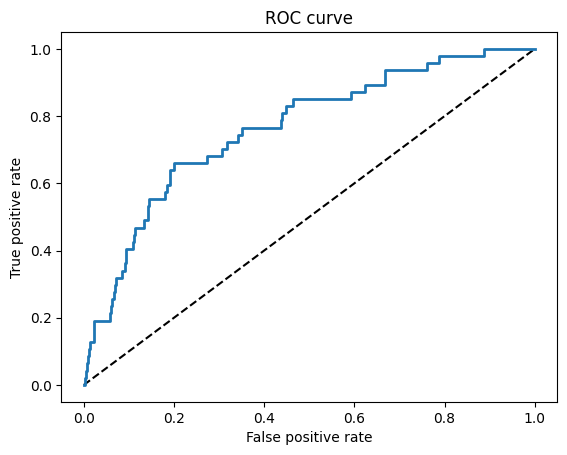

Area under curve, AUC =  0.7642899763775022


In [20]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, focal_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, linewidth = 2, label = None)
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [12]:
test_generator = test_datagen.flow_from_dataframe(
    test_gen,
    x_col='image_dir',
    y_col='target',
    target_size=(224, 224),
    batch_size=64,
    class_mode='raw',
    shuffle=False
)

Found 2650 validated image filenames.


In [13]:

kaggle_test_path='./melanoma-image-data/test/test'
test_set_kaggle = test_datagen.flow_from_directory(kaggle_test_path,
                                             target_size = (224,224),
                                             batch_size = 64,
                                             class_mode = 'categorical',
                                             shuffle=False)

test_set_kaggle.reset()

Found 10982 images belonging to 1 classes.


In [23]:
kaggle_pred_test = focalloss_model.predict_generator(test_set_kaggle,verbose=1)
print(kaggle_pred_test)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  """Entry point for launching an IPython kernel.


172/172 [==============================] - 1065s 6s/step
[[0.00881885]
 [0.01950783]
 [0.00527181]
 ...
 [0.36966798]
 [0.01469972]
 [0.13293007]]


In [24]:
# Malignent Prediction
imbalanced_predict_malignent=[]
for i in range(len(kaggle_pred_test)):
    imbalanced_predict_malignent.append(kaggle_pred_test[i]) 

#print(imbalanced_predict_class_kaggle)
imbalanced_np_malignent=np.asarray(imbalanced_predict_malignent, dtype=None)
imbalanced_np_malignent=imbalanced_np_malignent.ravel()

In [25]:
import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":imbalanced_np_malignent})
results.to_csv("ResNet_focalLoss_Result.csv",index=False)

In [15]:
train_classes=y_train
from sklearn.utils import compute_class_weight

class_weights = compute_class_weight(
                                        class_weight = 'balanced',
                                        classes = np.unique(train_classes),
                                        y = train_classes
) 
class_weights = dict(zip(np.unique(train_classes),class_weights))
class_weights

{0: 0.5089628681177977, 1: 28.392857142857142}

In [18]:
from datetime import datetime
from keras.callbacks import ModelCheckpoint,EarlyStopping



mc = ModelCheckpoint(filepath='InceptionResNetV2_weighted_AUC_model1.h5',
                     monitor='val_auc',  # even use the generated handle for monitoring the training AUC
                     save_best_only=True,
                     mode='max')

#Early stopping
es = EarlyStopping(monitor = 'val_auc', patience = 3, mode='max',min_delta = 0.01)

callbacks = [mc,es]

start = datetime.now()


model.fit_generator(
    train_generator,
    steps_per_epoch=128,
    epochs=30,
    validation_data=validation_generator,
    callbacks=callbacks,
    validation_steps=64,
    class_weight=class_weights,
     verbose=1

)



duration = datetime.now() - start
print("Training completed in time: ", duration)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:27: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


Epoch 1/30
128/128 [==============================] - 1729s 14s/step - loss: 0.5094 - auc: 0.6449 - val_loss: 0.3168 - val_auc: 0.7897
Epoch 2/30
128/128 [==============================] - 1522s 12s/step - loss: 0.4709 - auc: 0.6892 - val_loss: 0.3866 - val_auc: 0.7845
Epoch 3/30
128/128 [==============================] - 1413s 11s/step - loss: 0.4918 - auc: 0.7213 - val_loss: 0.1227 - val_auc: 0.7918
Epoch 4/30
128/128 [==============================] - 1368s 11s/step - loss: 0.5455 - auc: 0.7306 - val_loss: 0.3141 - val_auc: 0.8307
Epoch 5/30
128/128 [==============================] - 1346s 11s/step - loss: 0.4748 - auc: 0.7402 - val_loss: 0.3678 - val_auc: 0.8111
Epoch 6/30
128/128 [==============================] - 1331s 10s/step - loss: 0.4505 - auc: 0.7327 - val_loss: 0.0934 - val_auc: 0.8181
Epoch 7/30
128/128 [==============================] - 1327s 10s/step - loss: 0.6151 - auc: 0.7258 - val_loss: 0.1312 - val_auc: 0.8150
Training completed in time:  2:48:20.723288


In [21]:
#load best model
from keras.models import load_model

# Load best fit model
weighted_model = load_model('InceptionResNetV2_weighted_AUC_model1.h5')

results = weighted_model.evaluate_generator(generator=test_generator,verbose = 1)
print(" Test loss and accuracy are", results)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  import sys


42/42 [==============================] - 260s 6s/step - loss: 0.3435 - auc: 0.8093
 Test loss and accuracy are [0.3434715270996094, 0.8092749118804932]


In [22]:
balanced_pred = weighted_model.predict(test_generator,verbose = 1)
print(balanced_pred)

42/42 [==============================] - 261s 6s/step
[[0.2576631 ]
 [0.03901874]
 [0.02310927]
 ...
 [0.36081132]
 [0.04120907]
 [0.65676683]]


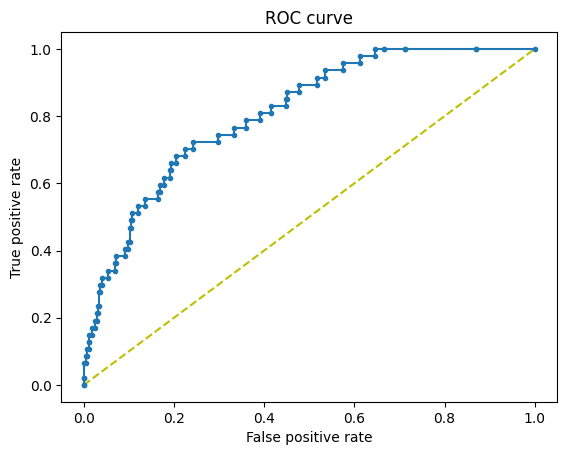

Area under curve, AUC =  0.8093525473880383


In [23]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, balanced_pred)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

# Model with average / sum Ensemble

In [26]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('InceptionResNetV2_focalloss_AUC_model1.h5')
model2 = load_model('InceptionResNetV2_weighted_AUC_model1.h5')

models = [model1, model2]

ensemble_pred = [model.predict(test_generator) for model in models]



42/42 [==============================] - 261s 6s/step


NameError: name 'preds' is not defined

In [28]:
ensemble_pred=np.array(ensemble_pred)

In [61]:
weights = [0.2, 0.8]

In [62]:
weighted_preds = np.tensordot(ensemble_pred, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)

[0.20984915 0.03597477 0.02176241 ... 0.29937503 0.03547137 0.53939655]


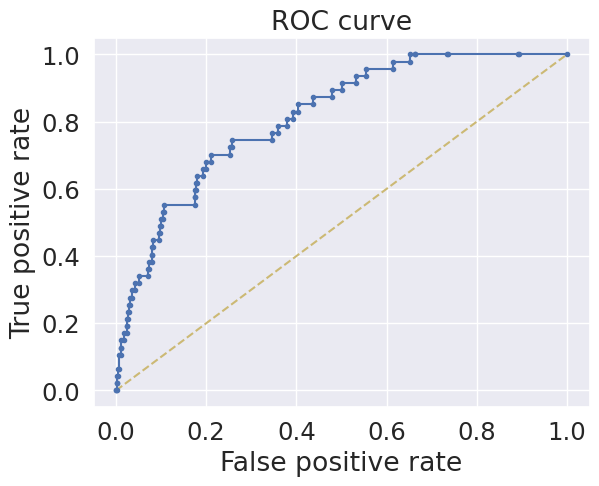

Area under curve, AUC =  0.8154257362617602


In [63]:
from sklearn.metrics import roc_curve


fpr, tpr, thresholds = roc_curve(test_gen.target, weighted_ensemble_prediction)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'y--')
plt.plot(fpr, tpr, marker='.')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.show()

from sklearn.metrics import auc
auc_value = auc(fpr, tpr)
print("Area under curve, AUC = ", auc_value)

In [64]:
balanced_pred_conf=weighted_ensemble_prediction
for i in range(len(balanced_pred_conf)):
    if (balanced_pred_conf[i]>0.5):
        balanced_pred_conf[i] = 1
    else:
        balanced_pred_conf[i] = 0
balanced_pred_conf

array([0., 0., 0., ..., 0., 0., 1.])

<AxesSubplot:>

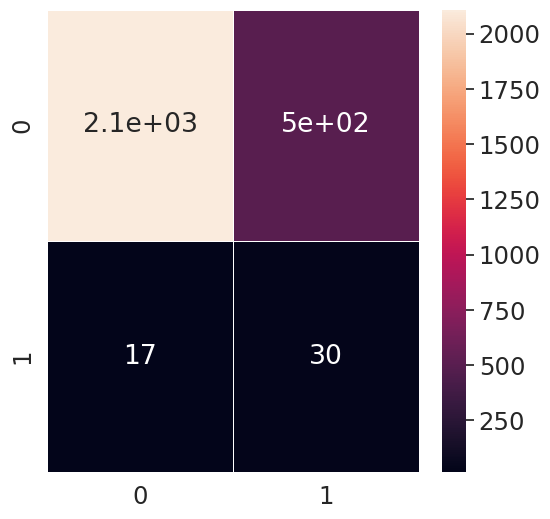

In [65]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test_conf, balanced_pred_conf)

fig, ax = plt.subplots(figsize=(6,6))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

In [14]:
from keras.models import load_model
from sklearn.metrics import accuracy_score

model1 = load_model('InceptionResNetV2_focalloss_AUC_model1.h5')
model2 = load_model('InceptionResNetV2_weighted_AUC_model1.h5')

models = [model1, model2]

In [15]:

kaggle_pred_test= [model.predict(test_set_kaggle,verbose=1) for model in models]
kaggle_pred_test=np.array(kaggle_pred_test)

weights = [0.2, 0.8]
weighted_preds = np.tensordot(kaggle_pred_test, weights, axes=((0),(0)))
weighted_ensemble_prediction = np.average(weighted_preds, axis=1)
print(weighted_ensemble_prediction)


172/172 [==============================] - 1681s 10s/step
[0.0233654  0.02630687 0.42722657 ... 0.58464088 0.11424077 0.06703029]


In [16]:
ensemble_predict_malignent=np.asarray(weighted_ensemble_prediction, dtype=None)
ensemble_predict_malignent=ensemble_predict_malignent.ravel()

import pandas as pd
filenames=test_set_kaggle.filenames
results=pd.DataFrame({"image_name":filenames,
                      "target":ensemble_predict_malignent})
results.to_csv("Inception_Ensemble_results_final.csv",index=False)